# Example: Spatially varying advection

In [1]:
import spdepy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
bc = 1

M = 50
N = 50
T = 12
x = np.linspace(0, 15, M)
y = np.linspace(0, 15, N)
ts = np.linspace(0,2,T).astype("float64")

# np.savez("data/grid.npz", x=x, y=y, t=ts)

Text(0, 0.5, 'y')

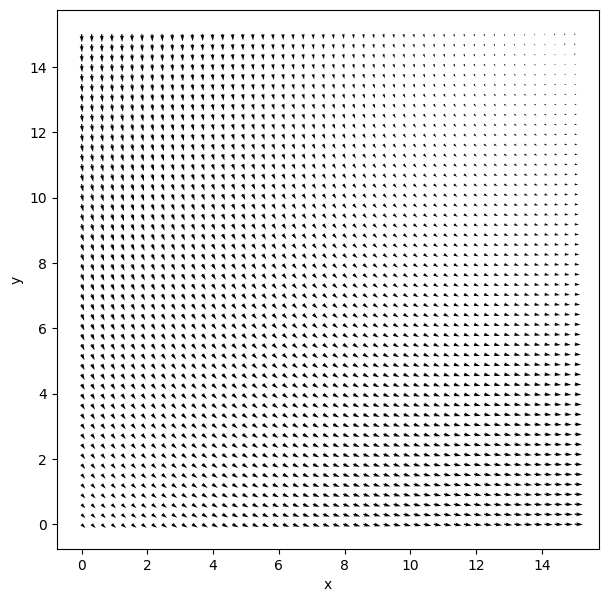

In [3]:

X, Y, _= np.meshgrid(x, y, ts)
sx, sy = np.meshgrid(x, y)
sx = sx.flatten()
sy = sy.flatten()

def getVx(x,y):
    return np.sin((x/15+1/2)*np.pi/3)*np.cos((y/15+1/2)*np.pi/3)

def getVy(x,y):
    return -np.cos((x/15+1/2)*np.pi/3)*np.sin((y/15+1/2)*np.pi/3)

def getPerpVx(x,y):
    return -np.cos((x/15+1/2)*np.pi/3)*np.sin((y/15 + 1/2)*np.pi/3)

def getPerpVy(x,y):
    return -np.sin((x/15+1/2)*np.pi/3)*np.cos((y/15+1/2)*np.pi/3)

def getVx(x,y):
    return np.sin((x/15+1/2))*np.cos((y/15+1/2))
def getVy(x,y):
    return -np.cos((x/15+1/2))*np.sin((y/15+1/2))
def getPerpVx(x,y):
    return -np.cos((x/15+1/2))*np.sin((y/15 + 1/2))
def getPerpVy(x,y):
    return -np.sin((x/15+1/2))*np.cos((y/15+1/2))
    
vx = getVx(X,Y)
vy = getVy(X,Y)

fig, ax = plt.subplots(figsize=(7, 7))
rect = plt.Rectangle((4,4),6,6,linewidth=1,edgecolor='r',facecolor='none')
ax.quiver(X[:,:,0], Y[:,:,0], vx[:,:,0], vy[:,:,0])
# ax.add_patch(rect)
ax.set_xlabel('x')
ax.set_ylabel('y')
# fig.savefig("../../../spat_temp_paper/figures/simstud_vec1.png", dpi=200)

Text(0, 0.5, 'y')

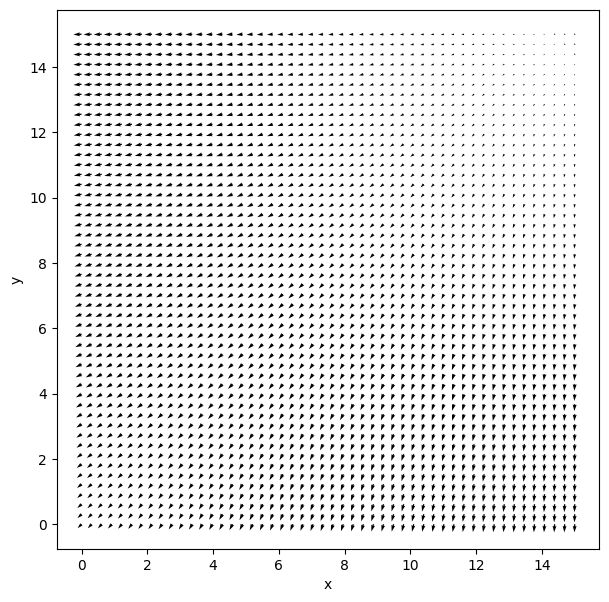

In [4]:
vx = getPerpVx(X,Y)
vy = getPerpVy(X,Y)

fig, ax = plt.subplots(figsize=(7, 7))
rect = plt.Rectangle((4,4),6,6,linewidth=1,edgecolor='r',facecolor='none')
ax.quiver(X[:,:,0], Y[:,:,0], vx[:,:,0], vy[:,:,0])
ax.set_xlabel('x')
ax.set_ylabel('y')
# fig.savefig("../../../spat_temp_paper/figures/simstud_vec2.png", dpi=200)

In [5]:
mod = sp.model(grid = sp.grid(x=x, y=y, t = ts), spde = 'var-advection-var-diffusion', 
               ha = False, bc = bc, anisotropic = True)

In [6]:
from scipy.optimize import minimize
svxa = getVx(sx,sy)
svya = getVy(sx,sy)
svxd = getPerpVx(sx,sy)
svyd = getPerpVy(sx,sy)

    
def findPerpVx(par):
    res = ((mod.grid.evalB(par = par) - svxd)**2).mean()
    return res

def findPerpVy(par):
    res = ((mod.grid.evalB(par = par) - svyd)**2).mean()
    return res
    
def findVx(par):
    res = ((mod.grid.evalB(par = par) - svxa)**2).mean()
    return res

def findVy(par):
    res = ((mod.grid.evalB(par = par) - svya)**2).mean()
    return res

resd1 = minimize(findPerpVx, x0 = np.random.normal(size = 9), method = "Nelder-Mead")
resd2 = minimize(findPerpVy, x0 = np.random.normal(size = 9), method = "Nelder-Mead")
resd1 = minimize(findPerpVx, x0 = resd1.x, method = "Nelder-Mead")
resd2 = minimize(findPerpVy, x0 = resd2.x, method = "Nelder-Mead")
resa1 = minimize(findVx, x0 = np.random.normal(size = 9), method = "Nelder-Mead")
resa2 = minimize(findVy, x0 = np.random.normal(size = 9), method = "Nelder-Mead")
resa1 = minimize(findVx, x0 = resa1.x, method = "Nelder-Mead")
resa2 = minimize(findVy, x0 = resa2.x, method = "Nelder-Mead")

Text(0, 0.5, 'y')

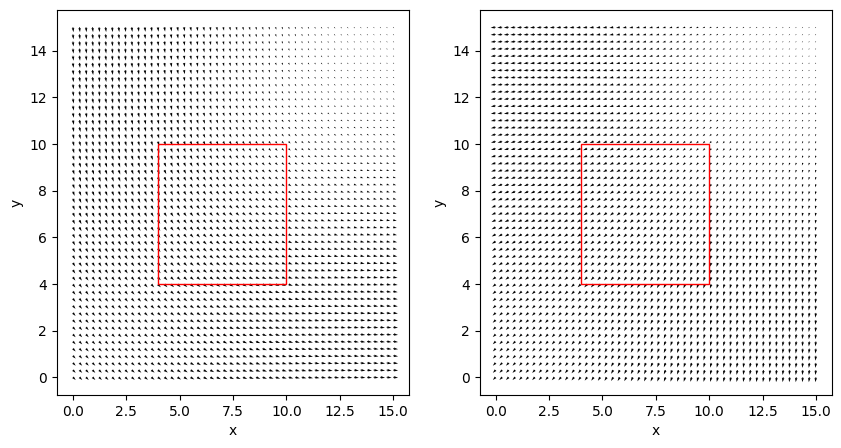

In [7]:
fig, ax = plt.subplots(ncols = 2,figsize=(10, 5))
rect1 = plt.Rectangle((4,4),6,6,linewidth=1,edgecolor='r',facecolor='none')
rect2 = plt.Rectangle((4,4),6,6,linewidth=1,edgecolor='r',facecolor='none')
ax[0].quiver(X[:,:,0], Y[:,:,0], mod.grid.evalB(par = resa1.x).reshape(N,M), mod.grid.evalB(par = resa2.x).reshape(N,M))
ax[1].quiver(X[:,:,0], Y[:,:,0], mod.grid.evalB(par = resd1.x).reshape(N,M), mod.grid.evalB(par = resd2.x).reshape(N,M))
ax[0].add_patch(rect1)
ax[1].add_patch(rect2)
ax[0].set_xlabel('x')
ax[1].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_ylabel('y')

In [11]:
parS = np.array([0,-0.5,np.log(1000)])
# np.save("data/mod0pars.npy", parS)
parT = np.hstack([[-2]*9,[-1]*9,resd1.x*0.7,resd2.x*0.7,resa1.x*30,resa2.x*30,-4,np.log(1000)])
mod0 = sp.model(grid = sp.grid(x=x, y=y, extend = 5),
         spde = 'whittle-matern', parameters = parS, ha = False, bc = bc, anisotropic = False)
# np.save('data/modpars.npy', parT)
mod = sp.model(grid = sp.grid(x=x, y=y, t = ts, extend = 5),
        spde = 'var-advection-var-diffusion', ha = False, bc = bc, anisotropic = True, mod0 = mod0, parameters = parT)


mod.setModel()
# data = mod.sample()[:,0]
# res = np.zeros((mod.grid.T,mod.grid.T))
# for t in range(mod.grid.T):
#     mod.setModel()
#     tidx = np.array([mod.grid.getIdx([x,y,t],extend = False) for x in range(mod.grid.M) for y in range(mod.grid.N)])
#     mod.update(y = data[tidx],idx = tidx, tau = 1000)
#     tmp2 = (mod.grid.getS()@mod.mu).reshape(mod.grid.T, mod.grid.N,mod.grid.M)
#     res[t,:] = np.sqrt((mod.grid.getS()@mod.mu - data)**2).reshape(mod.grid.T, mod.grid.M*mod.grid.N).mean(axis = 1)

# im = list()
# fig, ax = plt.subplots(figsize = (20,10),ncols=4,nrows=3)
# for t in range(mod.grid.T):
#     ax[t//4,t%4].plot(res[t,:])
   

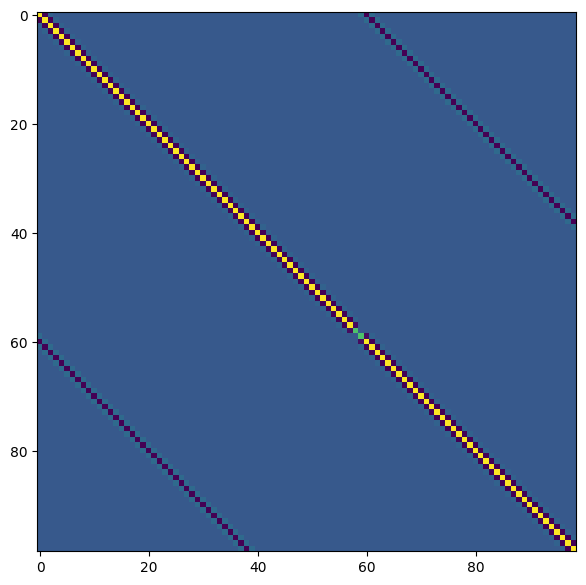

In [33]:
fig, ax = plt.subplots(figsize = (10,7))
im = ax.imshow(mod.mod.Q[301:400,301:400].toarray())
# fig.colorbar(im, ax=ax)

- Parameterized varying advection (Simulated from)
- Simple advection diffusion model
- Spatial model
- Seperable space time model (possbily complex)

In [9]:
tmp = mod.sample(n = 20,seed = 69)
tmp2 = np.ma.masked_array(tmp, mask = np.zeros (tmp.shape))
idx = []
idxS = []
for t in range(T):
    for i in range(M):
        for j in range(N):
            if 19 < i < 38:
                if 12 < j < 31:
                    tmp2.mask[t*M*N + j*M + i] = True
                    idx.append(t*M*N + j*M + i)
                    if t == 0:
                        idxS.append(j*M + i)
                    
idxD = np.delete(np.arange(0,M*N*T),idx)
idxDS = np.delete(np.arange(0,M*N),idxS)
tmp3 = np.zeros((M*N,T*tmp.shape[1]))
for i in range(tmp.shape[1]):
    tmp3[:,i*T:(i+1)*T] = tmp[:,i].reshape(T,N*M).T                    
# np.save("data/data.npy", tmp[idxD,:])
# np.save("data/dataS.npy", tmp3[idxDS,:])
# np.save("data/idxD.npy", idxD)
# np.save("data/idxDS.npy", idxDS)
# np.save("data/idx.npy", idx)
# np.save("data/idxS.npy", idxS)
# np.save("data/test.npy", tmp)
# np.save("data/testS.npy", tmp3)

In [35]:
np.diff(mod.grid.x[20:38][[0,-1]])*np.diff(mod.grid.y[12:31][[0,-1]])/(np.diff(mod.grid.x[ [0,-1] ])*np.diff(mod.grid.y[[0,-1]]))

array([0.1274469])

In [10]:
mod.grid.x[20]

6.122448979591837

In [11]:
mod.grid.x[38]

11.63265306122449

In [12]:
mod.grid.y[12]

3.673469387755102

In [13]:
mod.grid.y[31]

9.489795918367347

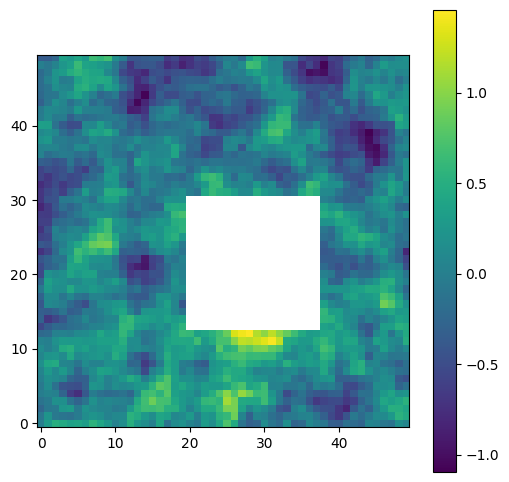

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(tmp2[:,6].reshape(T,N,M)[0,:,:],origin='lower')
clb = fig.colorbar(im, ax=ax)

## Make video and paper picture

In [103]:
import cv2

In [104]:
ver = 11
shind = np.array([0,10,20,30,40,49])
cmax = tmp[:,ver].max()
cmin = tmp[:,ver].min()
for i in range(T):
    fig, ax = plt.subplots(figsize=(8, 6))
    # ax.pcolormesh(mod.grid.x, mod.grid.y, tmp[:,ver].reshape(T,N,M)[i,:,:],cmap = "viridis",vmin = cmin, vmax = cmax,shading='gouraud')
    ax.imshow(tmp[:,ver].reshape(T,N,M)[i,:,:],origin='lower',alpha = 0.5, cmap = "viridis",vmin = cmin, vmax = cmax, extent=[0,max(mod.grid.x),0,max(mod.grid.y)])
    # im = ax.pcolormesh(mod.grid.x, mod.grid.y, tmp2[:,ver].reshape(T,N,M)[i,:,:],cmap = "viridis",vmin = cmin, vmax = cmax,shading='gouraud')
    im = ax.imshow(tmp2[:,ver].reshape(T,N,M)[i,:,:],origin='lower',cmap = "viridis",vmin = cmin, vmax = cmax, interpolation='none',extent=[0,max(mod.grid.x),0,max(mod.grid.y)])
    clb = fig.colorbar(im, ax=ax)
    ax.set_xlabel('x', fontsize = 15)
    ax.set_ylabel('y', fontsize = 15)
    # ax.set_xticks(mod.grid.x[shind],np.array(["%.1f"%xs for xs in x])[shind])
    # ax.set_yticks(mod.grid.y[shind],np.array(["%.1f"%ys for ys in y])[shind])
    fig.suptitle('t = %.2f'%(mod.grid.t[i]), fontsize = 15, y = 0.92, x = 0.48)
    fig.savefig("video/t%02d.png"%i,dpi = 200, bbox_inches = "tight")
    fig.set_size_inches(8, 6, forward=True)
    plt.close()

img = cv2.imread('video/t00.png')
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter('./video/videoAD.mp4', fourcc, 1.5, (img.shape[1], img.shape[0]))
video.write(img)
for i in range(1,T):
    img = cv2.imread('video/t%02d.png'%i)
    video.write(img)

cv2.destroyAllWindows()
video.release()

## Evaluate the results

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tmp = np.load("data/test/temporal_res5.npz",allow_pickle=True)
resTrue, resTrue2, resAD, resAD2, resSST, resSST2, resvAvD, resvAvD2 = tmp['resTrue'], tmp['resTrue2'], tmp['resAD'], tmp['resAD2'], tmp['resSST'], tmp['resSST2'], tmp['resvAvD'], tmp['resvAvD2']

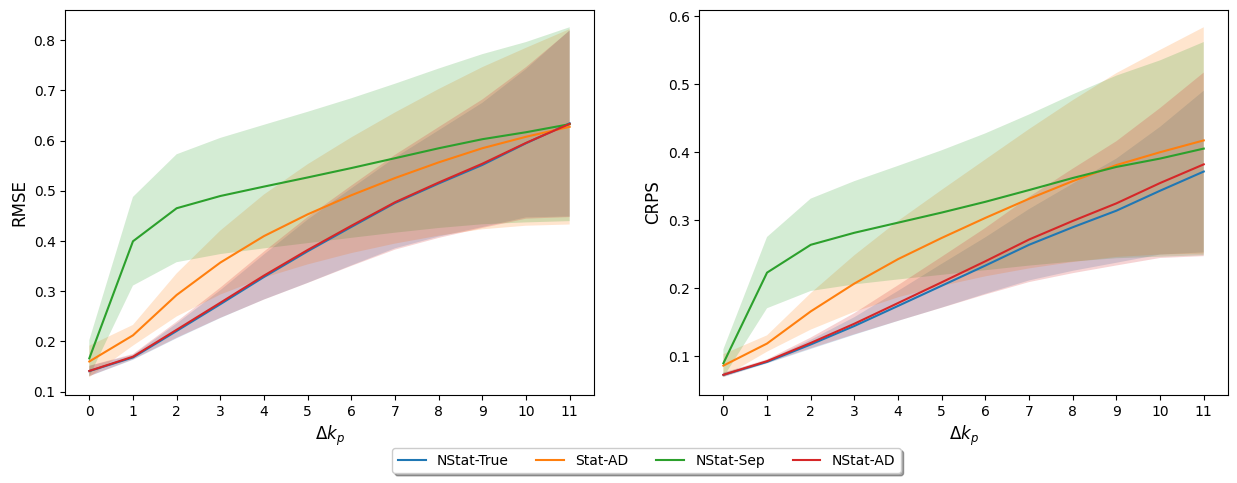

In [4]:
fig, ax = plt.subplots(figsize=(15, 5),ncols = 2)
ns = 12 
stm = np.arange(ns).astype("int32")
ax[0].plot(stm,resTrue.mean(axis=0)[:ns], label = 'NStat-True')
ax[1].plot(stm,resTrue2.mean(axis=0)[:ns], label = 'NStat-True')
ax[0].fill_between(stm, ( resTrue.mean(axis=0) - resTrue.std(axis=0) )[:ns], (resTrue.mean(axis=0) + resTrue.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, ( resTrue2.mean(axis=0) - resTrue2.std(axis=0) )[:ns], (resTrue2.mean(axis=0) + resTrue2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resAD.mean(axis = 0)[:ns], label = 'Stat-AD')
ax[1].plot(stm,resAD2.mean(axis = 0)[:ns], label = 'Stat-AD')
ax[0].fill_between(stm, (resAD.mean(axis=0) - resAD.std(axis=0))[:ns], (resAD.mean(axis=0) + resAD.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resAD2.mean(axis=0) - resAD2.std(axis=0))[:ns], (resAD2.mean(axis=0) + resAD2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resSST.mean(axis = 0)[:ns], label = 'NStat-Sep')
ax[1].plot(stm,resSST2.mean(axis = 0)[:ns], label = 'NStat-Sep')
ax[0].fill_between(stm, (resSST.mean(axis=0) - resSST.std(axis=0))[:ns], (resSST.mean(axis=0) + resSST.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resSST2.mean(axis=0) - resSST2.std(axis=0))[:ns], (resSST2.mean(axis=0) + resSST2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resvAvD.mean(axis = 0)[:ns], label = 'NStat-AD')
ax[1].plot(stm,resvAvD2.mean(axis = 0)[:ns], label = 'NStat-AD')
ax[0].fill_between(stm, (resvAvD.mean(axis=0) - resvAvD.std(axis=0))[:ns], (resvAvD.mean(axis=0) + resvAvD.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resvAvD2.mean(axis=0) - resvAvD2.std(axis=0))[:ns], (resvAvD2.mean(axis=0) + resvAvD2.std(axis=0))[:ns], alpha = 0.2)
ax[0].set_xticks(stm)
ax[1].set_xticks(stm)

ax[1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.12),
          fancybox=True, shadow=True, ncol=4)
ax[0].set_xlabel(r'$\Delta  k_p$',fontsize = 12)
ax[1].set_xlabel(r'$\Delta  k_p$',fontsize = 12)
ax[0].set_ylabel('RMSE',fontsize = 12)
ax[1].set_ylabel('CRPS',fontsize = 12)

fig.savefig("../../../spat_temp_paper/figures/simstud_advection_diffusion_full.png",bbox_inches='tight',dpi = 200)

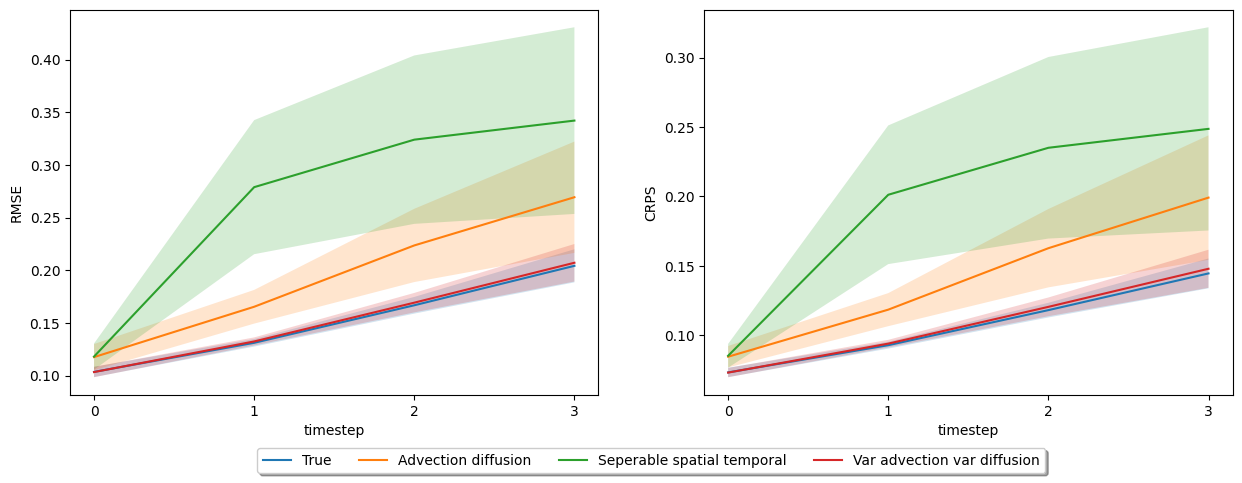

In [27]:
fig, ax = plt.subplots(figsize=(15, 5),ncols = 2)
ns = 4
stm = np.arange(ns).astype("int32")
ax[0].plot(stm,resTrue.mean(axis=0)[:ns], label = 'True')
ax[1].plot(stm,resTrue2.mean(axis=0)[:ns], label = 'True')
ax[0].fill_between(stm, ( resTrue.mean(axis=0) - resTrue.std(axis=0) )[:ns], (resTrue.mean(axis=0) + resTrue.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, ( resTrue2.mean(axis=0) - resTrue2.std(axis=0) )[:ns], (resTrue2.mean(axis=0) + resTrue2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resAD.mean(axis = 0)[:ns], label = 'Advection diffusion')
ax[1].plot(stm,resAD2.mean(axis = 0)[:ns], label = 'Advection diffusion')
ax[0].fill_between(stm, (resAD.mean(axis=0) - resAD.std(axis=0))[:ns], (resAD.mean(axis=0) + resAD.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resAD2.mean(axis=0) - resAD2.std(axis=0))[:ns], (resAD2.mean(axis=0) + resAD2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resSST.mean(axis = 0)[:ns], label = 'Separable spatial temporal')
ax[1].plot(stm,resSST2.mean(axis = 0)[:ns], label = 'Separable spatial temporal')
ax[0].fill_between(stm, (resSST.mean(axis=0) - resSST.std(axis=0))[:ns], (resSST.mean(axis=0) + resSST.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resSST2.mean(axis=0) - resSST2.std(axis=0))[:ns], (resSST2.mean(axis=0) + resSST2.std(axis=0))[:ns], alpha = 0.2)
ax[0].plot(stm,resvAvD.mean(axis = 0)[:ns], label = 'Var advection var diffusion')
ax[1].plot(stm,resvAvD2.mean(axis = 0)[:ns], label = 'Var advection var diffusion')
ax[0].fill_between(stm, (resvAvD.mean(axis=0) - resvAvD.std(axis=0))[:ns], (resvAvD.mean(axis=0) + resvAvD.std(axis=0))[:ns], alpha = 0.2)
ax[1].fill_between(stm, (resvAvD2.mean(axis=0) - resvAvD2.std(axis=0))[:ns], (resvAvD2.mean(axis=0) + resvAvD2.std(axis=0))[:ns], alpha = 0.2)
ax[0].set_xticks(stm)
ax[1].set_xticks(stm)

ax[1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.12),
          fancybox=True, shadow=True, ncol=4)
ax[0].set_xlabel('timestep')
ax[1].set_xlabel('timestep')
ax[0].set_ylabel('RMSE')
ax[1].set_ylabel('CRPS')

fig.savefig("../../../spat_temp_paper/figures/simstud_advection_diffusion.png",bbox_inches='tight',dpi = 200)

## Visualization

In [28]:
import numpy as np
import spdepy as sp
import plotly.graph_objs as go
from plotly.offline import plot
from plotly.subplots import make_subplots
import plotly.io as pio
bc = 1
grid = np.load('data/grid.npz')
mod0 = sp.model(grid = sp.grid(x=grid['x'], y=grid['y'], extend = 5),
        spde = 'whittle-matern', parameters = np.load('data/mod0pars.npy'),
        ha = False, bc = bc, anisotropic = False)
mod = sp.model(grid = sp.grid(x=grid['x'], y=grid['y'], t = grid['t'],extend = 5),
        spde = 'var-advection-var-diffusion', ha = False, bc = bc, anisotropic = True, mod0 = mod0, parameters = np.load('data/modpars.npy'))
mod.setModel()

In [29]:
mvar = mod.qinv(simple = True)
pos = [15,45,2]
ik = np.zeros(mod.grid.n)
k = mod.grid.getIdx(pos)
ks = mod.grid.getIdx(pos,extend = False)
ik[k] = 1
cov = mod.grid.getS()@mod.Q_fac.solve_A(ik)
corr = cov/np.sqrt(mvar[ks]*mvar)

tmp = mod.sample(n = 20,seed = 69)
tmp2 = np.ma.masked_array(tmp, mask = np.zeros (tmp.shape))
for t in range(T):
    for i in range(M):
        for j in range(N):
            if 19 < i < 38:
                if 12 < j < 31:
                    tmp2.mask[t*M*N + j*M + i] = True
                    

In [30]:
# want to make this similar to my 3D plotting in GMRFpy
# using plotly, only now time downwards
import numpy as np
import spdepy as sp
import plotly.graph_objs as go
from plotly.offline import plot
from plotly.subplots import make_subplots
import plotly.io as pio
pio.orca.shutdown_server()
M = mod.grid.M
N = mod.grid.N
T = mod.grid.T
sx = mod.grid.sx
sy = mod.grid.sy
ts = mod.grid.t
value = corr.reshape(T,-1)
cmin = 0
cmax = 1
cs = "viridis"
xdif = mod.grid.A/4
ydif = mod.grid.B/4
xarrow = np.array([sx.max()-.497*xdif,sx.max()-.142*xdif,sx.max()-.142*xdif,sx.max()-.142*xdif,sx.max()-.355*xdif])
yarrow = np.array([sy.max()-.520*ydif,sy.max()-.164*ydif,sy.max()-.378*ydif,sy.max()-.164*ydif,sy.max() -.164*ydif])
vZ = np.array([0,0.705,1.67,3])
fig = go.Figure(data=[go.Isosurface(z=-0.5*np.ones(N*M), x=sx, y=sy,
                                    value=value[11,:],surface_count=1,
                                    isomin = cmin,isomax = cmax,colorscale=cs,
                                    colorbar=dict(thickness=20,lenmode = "fraction", 
                                                  len = 0.8, ticklen=10,
                                                  tickfont=dict(size=20, color='black')))])
for i in range(1,4):
    fig.add_trace(go.Isosurface(z=(-0.5 - vZ[i])*np.ones(N*M), x=sx+xdif*vZ[i], y=sy-ydif*vZ[i],
                                surface_count=1, value=value[11-3*i,:], isomin = cmin,
                                isomax =cmax,colorscale=cs,showscale = False))

if pos is not None:
    fig.add_trace(go.Scatter3d(mode = "markers", x=[sx[pos[1]*M + pos[0]]+xdif*3],
                               y = [sy[pos[1]*M + pos[0]]-ydif*3], 
                               z=[-3.5], marker_color="black",marker_size=7,showlegend = False))

for j in range(4):
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[0*M + 0, 0*M + (M-1)]]+xdif*vZ[j], 
                               y=[0,0]+sy[[0*M + 0, 0*M + (M-1)]]-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[0*M + 0, (N-1)*M + 0]]+xdif*vZ[j],
                               y=[0,0]+sy[[0*M + 0, (N-1)*M + 0]]-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[(N-1)*M + 0, (N-1)*M + (M-1)]]+xdif*vZ[j], 
                               y=[0,0]+sy[[(N-1)*M + 0, (N-1)*M + (M-1)]]-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[0*M + (M-1), (N-1)*M + (M-1)]]+xdif*vZ[j], 
                               y=[0,0]+sy[[0*M + (M-1), (N-1)*M + (M-1)]]+-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))

# axis 
fig.add_trace(go.Scatter3d(x=[0,0.213*xdif,0.114*xdif,0.213*xdif,0.114*xdif]+sx[[0*M + 0, 0*M + (M-1), 0*M + (M-1), 0*M + (M-1), 0*M + (M-1)]]+xdif*3, 
                            y=[0,0,0.099*ydif,0,-0.099*ydif]+sy[[0*M + 0, 0*M + (M-1), 0*M + (M-1), 0*M + (M-1), 0*M + (M-1)]]-ydif*3, 
                            z=np.array([-0.5,-0.5,-0.5,-0.5,-0.5])-3, mode='lines',
                            line = dict(color='black', width = 5),showlegend=False))
fig.add_trace(go.Scatter3d(x=[0,0,0.099*xdif,0,-0.099*xdif]+sx[[0*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1)]]+xdif*3, 
                            y=[0,0.213*ydif,0.114*ydif,0.213*ydif,0.114*ydif]+sy[[0*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1)]]+-ydif*3, 
                            z=np.array([-0.5,-0.5,-0.5,-0.5,-0.5])-3, mode='lines',
                            line = dict(color='black',width = 5),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[0*M + 1*(M-1)//4, 0*M + 2*(M-1)//4,0*M + 3*(M-1)//4, 0*M + (M-1)]]+xdif*3, 
                            y=sy[[0*M + 1*(M-1)//4, 0*M + 2*(M-1)//4,0*M + 3*(M-1)//4, 0*M + (M-1)]]-ydif*3, 
                            z=np.array([-0.5,-0.5,-0.5,-0.5])-3, mode='markers',
                            marker = dict(color='black', size = 2,symbol = "x"),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[1*(N-1)//4*M + (M-1), 2*(N-1)//4*M + (M-1), 3*(N-1)//4*M + (M-1), (N-1)*M + (M-1)]]+xdif*3,
                           y=sy[[1*(N-1)//4*M + (M-1), 2*(N-1)//4*M + (M-1), 3*(N-1)//4*M + (M-1), (N-1)*M + (M-1)]]+-ydif*3,
                           z=np.array([-0.5,-0.5,-0.5,-0.5])-3, mode='markers',
                           marker = dict(color='black', size = 2,symbol = "x"),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[0*M + 2*(M-1)//4]]+xdif*3, 
                            y=sy[[0*M + 2*(M-1)//4]]-ydif*3, 
                            z=np.array([-0.5])-3, mode='text',textposition="bottom left",
                            text = ["x"],textfont=dict(size=18,color="black"),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[2*(N-1)//4*M + (M-1)]]+xdif*3,
                           y=sy[[2*(N-1)//4*M + (M-1)]]+-ydif*3,
                           z=np.array([-0.5])-3, mode='text', textposition="bottom right",
                           text = ["y"],textfont=dict(size=18,color="black"),showlegend=False))
# lines
fig.add_trace(go.Scatter3d(
    x = np.array([xdif*3,-0.4*xdif,-0.3*xdif+xdif*0.099, -0.4*xdif,-0.3*xdif-xdif*0.099])+sx[0],
    y = np.array([-ydif*3,0.4*ydif,0.3*ydif + ydif*0.099, 0.4*ydif, 0.3*ydif-ydif*0.099])+sy[0],
    z = np.array([-3.5,-0.1,-0.2,-0.1,-0.2]),
    line=dict(color='black',width=7),
    mode='lines',
    showlegend=False))

# marker
fig.add_trace(go.Scatter3d(
    x = np.array([xdif]*4)*np.flip(vZ) + sx[0],
    y = np.array([-ydif]*4)*np.flip(vZ) + sy[0],
    z = np.array([-.5]*4) - np.flip(vZ),
    mode='markers',
    marker=dict(size=8, color="black",symbol = "cross"),
    showlegend=False))

# text
fig.add_trace(go.Scatter3d(
    x = np.array([xdif]*4)*np.flip(vZ) + sx[0],
    y = np.array([-ydif]*4)*np.flip(vZ) + sy[0],
    z = np.array([-.5]*4) - np.flip(vZ),
    mode='text',
    text=["%.1f"%ts[i] for i in range(2,12,3)],
    textfont=dict(size=18,color="black"),
    textposition="middle left",
    showlegend=False))
    
fig.add_trace(go.Scatter3d(
    x = np.array([-0.5*xdif])+sx[0],
    y = np.array([0.5*ydif])+sy[0],
    z = np.array([0.0]),
    mode='text',
    text=["Time"],
    textfont=dict(size=15,color="black"),
    textposition="middle center",
    showlegend=False))
    
# used for centering
fig.add_trace(go.Scatter3d(
    x = np.array([-0.5*xdif])+sx[-1],
    y = np.array([0.5*ydif])+sy[-1],
    z = [0.0],
    mode='text',
    text=[""],
    textfont=dict(size=15,color="black"),
    textposition="middle center",
    showlegend=False))
######

camera = dict(eye=dict(x=1.092, y=-1.12, z=.83), center=dict(x=0.13, y=-0.18, z=-0.042))
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False, camera = camera)
fig.update_layout(autosize=False, width=650, height=1000, scene_aspectratio=dict(x=1, y=1, z=1.0))

fig.write_html("test.html", auto_open = True)
fig.write_image("../../../spat_temp_paper/figures/simstud_corr.png",engine="orca",scale=1)



In [31]:
# want to make this similar to my 3D plotting in GMRFpy
# using plotly, only now time downwards
import numpy as np
import spdepy as sp
import plotly.graph_objs as go
from plotly.offline import plot
from plotly.subplots import make_subplots
import plotly.io as pio

pio.orca.shutdown_server()
M = mod.grid.M
N = mod.grid.N
T = mod.grid.T
sx = mod.grid.sx
sy = mod.grid.sy
ts = mod.grid.t
value = mvar.reshape(T,-1)
cmin = value.min()
cmax = value.max()
cs = "viridis"
xdif = mod.grid.A/4
ydif = mod.grid.B/4
xarrow = np.array([sx.max()-.497*xdif,sx.max()-.142*xdif,sx.max()-.142*xdif,sx.max()-.142*xdif,sx.max()-.355*xdif])
yarrow = np.array([sy.max()-.520*ydif,sy.max()-.164*ydif,sy.max()-.378*ydif,sy.max()-.164*ydif,sy.max() -.164*ydif])
vZ = np.array([0,0.705,1.67,3])
fig = go.Figure(data=[go.Isosurface(z=-0.5*np.ones(N*M), x=sx, y=sy,
                                    value=value[11,:],surface_count=1,
                                    isomin = cmin,isomax = cmax,colorscale=cs,
                                    colorbar=dict(thickness=20,lenmode = "fraction", 
                                                  len = 0.8, ticklen=10,
                                                  tickfont=dict(size=20, color='black')))])
for i in range(1,4):
    fig.add_trace(go.Isosurface(z=(-0.5 - vZ[i])*np.ones(N*M), x=sx+xdif*vZ[i], y=sy-ydif*vZ[i],
                                surface_count=1, value=value[11-3*i,:], isomin = cmin,
                                isomax =cmax,colorscale=cs,showscale = False))

for j in range(4):
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[0*M + 0, 0*M + (M-1)]]+xdif*vZ[j], 
                               y=[0,0]+sy[[0*M + 0, 0*M + (M-1)]]-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[0*M + 0, (N-1)*M + 0]]+xdif*vZ[j],
                               y=[0,0]+sy[[0*M + 0, (N-1)*M + 0]]-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[(N-1)*M + 0, (N-1)*M + (M-1)]]+xdif*vZ[j], 
                               y=[0,0]+sy[[(N-1)*M + 0, (N-1)*M + (M-1)]]-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[0*M + (M-1), (N-1)*M + (M-1)]]+xdif*vZ[j], 
                               y=[0,0]+sy[[0*M + (M-1), (N-1)*M + (M-1)]]+-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))

# axis 
fig.add_trace(go.Scatter3d(x=[0,0.213*xdif,0.114*xdif,0.213*xdif,0.114*xdif]+sx[[0*M + 0, 0*M + (M-1), 0*M + (M-1), 0*M + (M-1), 0*M + (M-1)]]+xdif*3, 
                            y=[0,0,0.099*ydif,0,-0.099*ydif]+sy[[0*M + 0, 0*M + (M-1), 0*M + (M-1), 0*M + (M-1), 0*M + (M-1)]]-ydif*3, 
                            z=np.array([-0.5,-0.5,-0.5,-0.5,-0.5])-3, mode='lines',
                            line = dict(color='black', width = 5),showlegend=False))
fig.add_trace(go.Scatter3d(x=[0,0,0.099*xdif,0,-0.099*xdif]+sx[[0*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1)]]+xdif*3, 
                            y=[0,0.213*ydif,0.114*ydif,0.213*ydif,0.114*ydif]+sy[[0*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1)]]+-ydif*3, 
                            z=np.array([-0.5,-0.5,-0.5,-0.5,-0.5])-3, mode='lines',
                            line = dict(color='black',width = 5),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[0*M + 1*(M-1)//4, 0*M + 2*(M-1)//4,0*M + 3*(M-1)//4, 0*M + (M-1)]]+xdif*3, 
                            y=sy[[0*M + 1*(M-1)//4, 0*M + 2*(M-1)//4,0*M + 3*(M-1)//4, 0*M + (M-1)]]-ydif*3, 
                            z=np.array([-0.5,-0.5,-0.5,-0.5])-3, mode='markers',
                            marker = dict(color='black', size = 2,symbol = "x"),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[1*(N-1)//4*M + (M-1), 2*(N-1)//4*M + (M-1), 3*(N-1)//4*M + (M-1), (N-1)*M + (M-1)]]+xdif*3,
                           y=sy[[1*(N-1)//4*M + (M-1), 2*(N-1)//4*M + (M-1), 3*(N-1)//4*M + (M-1), (N-1)*M + (M-1)]]+-ydif*3,
                           z=np.array([-0.5,-0.5,-0.5,-0.5])-3, mode='markers',
                           marker = dict(color='black', size = 2,symbol = "x"),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[0*M + 2*(M-1)//4]]+xdif*3, 
                            y=sy[[0*M + 2*(M-1)//4]]-ydif*3, 
                            z=np.array([-0.5])-3, mode='text',textposition="bottom left",
                            text = ["x"],textfont=dict(size=18,color="black"),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[2*(N-1)//4*M + (M-1)]]+xdif*3,
                           y=sy[[2*(N-1)//4*M + (M-1)]]+-ydif*3,
                           z=np.array([-0.5])-3, mode='text', textposition="bottom right",
                           text = ["y"],textfont=dict(size=18,color="black"),showlegend=False))
# lines
fig.add_trace(go.Scatter3d(
    x = np.array([xdif*3,-0.4*xdif,-0.3*xdif+xdif*0.099, -0.4*xdif,-0.3*xdif-xdif*0.099])+sx[0],
    y = np.array([-ydif*3,0.4*ydif,0.3*ydif + ydif*0.099, 0.4*ydif, 0.3*ydif-ydif*0.099])+sy[0],
    z = np.array([-3.5,-0.1,-0.2,-0.1,-0.2]),
    line=dict(color='black',width=7),
    mode='lines',
    showlegend=False))

# marker
fig.add_trace(go.Scatter3d(
    x = np.array([xdif]*4)*np.flip(vZ) + sx[0],
    y = np.array([-ydif]*4)*np.flip(vZ) + sy[0],
    z = np.array([-.5]*4) - np.flip(vZ),
    mode='markers',
    marker=dict(size=8, color="black",symbol = "cross"),
    showlegend=False))

# text
fig.add_trace(go.Scatter3d(
    x = np.array([xdif]*4)*np.flip(vZ) + sx[0],
    y = np.array([-ydif]*4)*np.flip(vZ) + sy[0],
    z = np.array([-.5]*4) - np.flip(vZ),
    mode='text',
    text=["%.1f"%ts[i] for i in range(2,12,3)],
    textfont=dict(size=18,color="black"),
    textposition="middle left",
    showlegend=False))
    
fig.add_trace(go.Scatter3d(
    x = np.array([-0.5*xdif])+sx[0],
    y = np.array([0.5*ydif])+sy[0],
    z = np.array([0.0]),
    mode='text',
    text=["Time"],
    textfont=dict(size=15,color="black"),
    textposition="middle center",
    showlegend=False))
    
# used for centering
fig.add_trace(go.Scatter3d(
    x = np.array([-0.5*xdif])+sx[-1],
    y = np.array([0.5*ydif])+sy[-1],
    z = [0.0],
    mode='text',
    text=[""],
    textfont=dict(size=15,color="black"),
    textposition="middle center",
    showlegend=False))
######

camera = dict(eye=dict(x=1.092, y=-1.12, z=.83), center=dict(x=0.13, y=-0.18, z=-0.042))
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False, camera = camera)
fig.update_layout(autosize=False, width=650, height=1000, scene_aspectratio=dict(x=1, y=1, z=1.0))

fig.write_html("test.html", auto_open = True)
fig.write_image("../../../spat_temp_paper/figures/simstud_mvar.png",engine="orca",scale=1)



In [32]:
# want to make this similar to my 3D plotting in GMRFpy
# using plotly, only now time downwards
import numpy as np
import spdepy as sp
import plotly.graph_objs as go
from plotly.offline import plot
from plotly.subplots import make_subplots
import plotly.io as pio

pio.orca.shutdown_server()
M = mod.grid.M
N = mod.grid.N
T = mod.grid.T
sx = mod.grid.sx
sy = mod.grid.sy
ts = mod.grid.t
use = 6
value = np.array(tmp2[:,use])
cmin = value.min()
cmax = value.max()
value[tmp2[:,use].mask] = 1e20
value = value.reshape(T,-1)
cs = "viridis"
xdif = mod.grid.A/4
ydif = mod.grid.B/4
xarrow = np.array([sx.max()-.497*xdif,sx.max()-.142*xdif,sx.max()-.142*xdif,sx.max()-.142*xdif,sx.max()-.355*xdif])
yarrow = np.array([sy.max()-.520*ydif,sy.max()-.164*ydif,sy.max()-.378*ydif,sy.max()-.164*ydif,sy.max() -.164*ydif])
vZ = np.array([0,0.705,1.67,3])
fig = go.Figure(data=[go.Isosurface(z=-0.5*np.ones(N*M), x=sx, y=sy,
                                    value=value[11,:],surface_count=1,
                                    isomin = cmin,isomax = cmax,colorscale=cs,
                                    colorbar=dict(thickness=20,lenmode = "fraction", 
                                                  len = 0.8, ticklen=10,
                                                  tickfont=dict(size=20, color='black')))])
for i in range(1,4):
    fig.add_trace(go.Isosurface(z=(-0.5 - vZ[i])*np.ones(N*M), x=sx+xdif*vZ[i], y=sy-ydif*vZ[i],
                                surface_count=1, value=value[11-3*i,:], isomin = cmin,
                                isomax =cmax,colorscale=cs,showscale = False))

for j in range(4):
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[0*M + 0, 0*M + (M-1)]]+xdif*vZ[j], 
                               y=[0,0]+sy[[0*M + 0, 0*M + (M-1)]]-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[0*M + 0, (N-1)*M + 0]]+xdif*vZ[j],
                               y=[0,0]+sy[[0*M + 0, (N-1)*M + 0]]-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[(N-1)*M + 0, (N-1)*M + (M-1)]]+xdif*vZ[j], 
                               y=[0,0]+sy[[(N-1)*M + 0, (N-1)*M + (M-1)]]-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))
    fig.add_trace(go.Scatter3d(x=[0,0]+sx[[0*M + (M-1), (N-1)*M + (M-1)]]+xdif*vZ[j], 
                               y=[0,0]+sy[[0*M + (M-1), (N-1)*M + (M-1)]]+-ydif*vZ[j], 
                               z=np.array([-0.5,-0.5])-vZ[j], mode='lines',
                               line = dict(color='black'),showlegend=False))

# axis 
fig.add_trace(go.Scatter3d(x=[0,0.213*xdif,0.114*xdif,0.213*xdif,0.114*xdif]+sx[[0*M + 0, 0*M + (M-1), 0*M + (M-1), 0*M + (M-1), 0*M + (M-1)]]+xdif*3, 
                            y=[0,0,0.099*ydif,0,-0.099*ydif]+sy[[0*M + 0, 0*M + (M-1), 0*M + (M-1), 0*M + (M-1), 0*M + (M-1)]]-ydif*3, 
                            z=np.array([-0.5,-0.5,-0.5,-0.5,-0.5])-3, mode='lines',
                            line = dict(color='black', width = 5),showlegend=False))
fig.add_trace(go.Scatter3d(x=[0,0,0.099*xdif,0,-0.099*xdif]+sx[[0*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1)]]+xdif*3, 
                            y=[0,0.213*ydif,0.114*ydif,0.213*ydif,0.114*ydif]+sy[[0*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1), (N-1)*M + (M-1)]]+-ydif*3, 
                            z=np.array([-0.5,-0.5,-0.5,-0.5,-0.5])-3, mode='lines',
                            line = dict(color='black',width = 5),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[0*M + 1*(M-1)//4, 0*M + 2*(M-1)//4,0*M + 3*(M-1)//4, 0*M + (M-1)]]+xdif*3, 
                            y=sy[[0*M + 1*(M-1)//4, 0*M + 2*(M-1)//4,0*M + 3*(M-1)//4, 0*M + (M-1)]]-ydif*3, 
                            z=np.array([-0.5,-0.5,-0.5,-0.5])-3, mode='markers',
                            marker = dict(color='black', size = 2,symbol = "x"),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[1*(N-1)//4*M + (M-1), 2*(N-1)//4*M + (M-1), 3*(N-1)//4*M + (M-1), (N-1)*M + (M-1)]]+xdif*3,
                           y=sy[[1*(N-1)//4*M + (M-1), 2*(N-1)//4*M + (M-1), 3*(N-1)//4*M + (M-1), (N-1)*M + (M-1)]]+-ydif*3,
                           z=np.array([-0.5,-0.5,-0.5,-0.5])-3, mode='markers',
                           marker = dict(color='black', size = 2,symbol = "x"),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[0*M + 2*(M-1)//4]]+xdif*3, 
                            y=sy[[0*M + 2*(M-1)//4]]-ydif*3, 
                            z=np.array([-0.5])-3, mode='text',textposition="bottom left",
                            text = ["x"],textfont=dict(size=18,color="black"),showlegend=False))
fig.add_trace(go.Scatter3d(x=sx[[2*(N-1)//4*M + (M-1)]]+xdif*3,
                           y=sy[[2*(N-1)//4*M + (M-1)]]+-ydif*3,
                           z=np.array([-0.5])-3, mode='text', textposition="bottom right",
                           text = ["y"],textfont=dict(size=18,color="black"),showlegend=False))
# lines
fig.add_trace(go.Scatter3d(
    x = np.array([xdif*3,-0.4*xdif,-0.3*xdif+xdif*0.099, -0.4*xdif,-0.3*xdif-xdif*0.099])+sx[0],
    y = np.array([-ydif*3,0.4*ydif,0.3*ydif + ydif*0.099, 0.4*ydif, 0.3*ydif-ydif*0.099])+sy[0],
    z = np.array([-3.5,-0.1,-0.2,-0.1,-0.2]),
    line=dict(color='black',width=7),
    mode='lines',
    showlegend=False))
    
# marker
fig.add_trace(go.Scatter3d(
    x = np.array([xdif]*4)*np.flip(vZ) + sx[0],
    y = np.array([-ydif]*4)*np.flip(vZ) + sy[0],
    z = np.array([-.5]*4) - np.flip(vZ),
    mode='markers',
    marker=dict(size=8, color="black",symbol = "cross"),
    showlegend=False))

# text
fig.add_trace(go.Scatter3d(
    x = np.array([xdif]*4)*np.flip(vZ) + sx[0],
    y = np.array([-ydif]*4)*np.flip(vZ) + sy[0],
    z = np.array([-.5]*4) - np.flip(vZ),
    mode='text',
    text=["%.1f"%ts[i] for i in range(2,12,3)],
    textfont=dict(size=18,color="black"),
    textposition="middle left",
    showlegend=False))
    
fig.add_trace(go.Scatter3d(
    x = np.array([-0.5*xdif])+sx[0],
    y = np.array([0.5*ydif])+sy[0],
    z = np.array([0.0]),
    mode='text',
    text=["Time"],
    textfont=dict(size=15,color="black"),
    textposition="middle center",
    showlegend=False))
    
# used for centering
fig.add_trace(go.Scatter3d(
    x = np.array([-0.5*xdif])+sx[-1],
    y = np.array([0.5*ydif])+sy[-1],
    z = [0.0],
    mode='text',
    text=[""],
    textfont=dict(size=15,color="black"),
    textposition="middle center",
    showlegend=False))
######

camera = dict(eye=dict(x=1.11, y=-1.135, z=.83), center=dict(x=0.125, y=-0.18, z=-0.042))
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False, camera = camera)
fig.update_layout(autosize=False, width=650, height=1000, scene_aspectratio=dict(x=1, y=1, z=1.0))

fig.write_html("test.html", auto_open = True)
fig.write_image("../../../spat_temp_paper/figures/simstud_real.png",engine="orca",scale=1)
